In [209]:
import sys
# not best practice, but makes it easier to import from subdirectory
sys.path.insert(0, './lib')

import experiment as exp
import model as m
import plot
import predict

import numpy as np
import matplotlib.pyplot as plt

import os
import torch

import umap
import matplotlib
from sklearn.preprocessing import StandardScaler

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

_ = plt.rcParams['axes.grid'] = False # turn off grid

%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load experiment

In [210]:
expts = ['expt04', 'expt06', 'expt07', 'expt09', 'expt11']
#e = exp.load('iter_exps03', experiment_location='experiments', datadir='Mdata')
e = exp.load('iter_exps06_5iters', experiment_location='experiments', datadir='Mdata')
e.trials_df

,trial_idx,model_name,expt,num_iter,num_filters,layer1_num_lags,name,trial,mean_LLs
0,0,TconvScaffoldIter,expt04,5,6,2,TconvScaffoldIter0,<experiment.Trial object at 0x7fbd6fa10a30>,0.479656
0,1,TconvScaffoldIter,expt04,5,6,2,TconvScaffoldIter1,<experiment.Trial object at 0x7fbd700da130>,0.479427
0,2,TconvScaffoldIter,expt04,5,6,2,TconvScaffoldIter2,<experiment.Trial object at 0x7fbd6f84b700>,0.475645
0,3,TconvScaffoldIter,expt04,5,6,2,TconvScaffoldIter3,<experiment.Trial object at 0x7fbd6f6bf4c0>,0.483760
0,4,TconvScaffoldIter,expt04,5,6,2,TconvScaffoldIter4,<experiment.Trial object at 0x7fbd6fd06af0>,0.478155
...,...,...,...,...,...,...,...,...,...
0,85,TconvScaffoldIter,expt04,5,6,2,TconvScaffoldIter85,<experiment.Trial object at 0x7fbd703712b0>,0.477552
0,86,TconvScaffoldIter,expt04,5,6,2,TconvScaffoldIter86,<experiment.Trial object at 0x7fbd6fc1e640>,0.481560
0,87,TconvScaffoldIter,expt04,5,6,2,TconvScaffoldIter87,<experiment.Trial object at 0x7fbd6fca84c0>,0.478300
0,88,TconvScaffoldIter,expt04,5,6,2,TconvScaffoldIter88,<experiment.Trial object at 0x7fbd7011d940>,0.478366


core
0 {'d2xt': 0.0001, 'center': 0.09066572866796363, 'bcs': {'d2xt': 1}}
1 {'activity': 0.00045663090134616033, 'd2xt': 0.0001, 'center': 0.0, 'bcs': {'d2xt': 1}}
readout
0 None


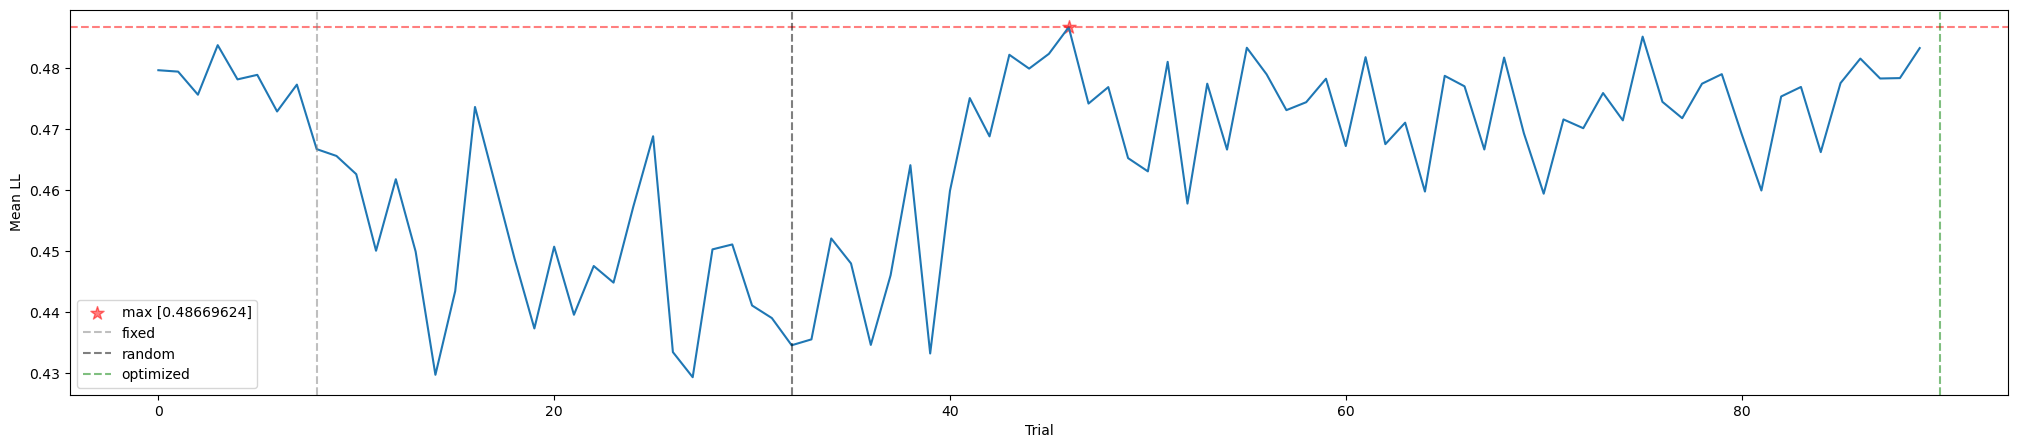

In [212]:
# plot the mean LLs for all the trials in a line chart
fig, ax = plt.subplots(figsize=(25,5))
mean_LLs = [np.mean(trial.LLs) for trial in e.trials]
max_LL = np.max(mean_LLs)
# get the index of the max LL
max_LL_idx = np.argmax(mean_LLs)
# print the reg_vals for the trial with the max LL
e.trials[max_LL_idx].model.print_params('reg_vals')

ax.plot(mean_LLs)

# put a horizontal dashed line at the max LL
ax.axhline(y=np.max(mean_LLs), color='red', linestyle='--', alpha=0.5)
# put an asterisk at the max LL as well
ax.scatter(np.argmax(mean_LLs), np.max(mean_LLs), marker='*', s=100, color='r', label='max ['+str(max_LL)+']', alpha=0.5)

# put a vertical dashed line at x=4 and x=10
ax.axvline(x=8, color='gray', linestyle='--', label='fixed', alpha=0.5)
ax.axvline(x=32, color='k', linestyle='--', label='random', alpha=0.5)
ax.axvline(x=90, color='g', linestyle='--', label='optimized', alpha=0.5)
ax.legend()
ax.set_xlabel('Trial')
ax.set_ylabel('Mean LL')
ax.set_title('mean LLs for model after 16 random samples, optimization for 50 steps')
plt.show()

# prepare weights

In [3]:
# sort the trials into models with the same parameters
models = {}
for trial in e.trials:
    num_filters = '.'.join([str(trial.model.networks[0].layers[0].params['num_filters']),
                            str(trial.model.networks[0].layers[1].params['num_filters'])])
    filter_widths = '.'.join([str(trial.model.networks[0].layers[0].params['filter_width']),
                              str(trial.model.networks[0].layers[1].params['filter_width'])])
    iter_filter_height = trial.model.networks[0].layers[1].params['num_lags']
    num_iter = trial.model.networks[0].layers[1].params['num_iter']
    if (num_filters, filter_widths, iter_filter_height, num_iter) in models:
        models[(num_filters, filter_widths, iter_filter_height, num_iter)].append(trial)
    else:
        models[(num_filters, filter_widths, iter_filter_height, num_iter)] = [trial]

models.keys()

dict_keys([('24.24', '17.7', 2, 3), ('24.24', '17.7', 2, 5), ('24.24', '17.7', 2, 7), ('24.24', '17.7', 2, 9)])

In [4]:
# get the best models by LL
best_trials = {}
for k,v in models.items():
    best_trials[k] = sorted(v, key=lambda x: np.mean(x.LLs), reverse=True)[0]
# print the params and mean LLs
for k,v in best_trials.items():
    print(k, '%.4f' % np.mean(v.LLs))

for k,v in best_trials.items():
    print(k)
    v.model.print_params('reg_vals')

print('--------')
for k,v in models.items():
    print(k, end=' = ')
    for trial in v:
        print('%.4f' % np.mean(trial.LLs), end=', ')
    print()

('24.24', '17.7', 2, 3) 0.1096
('24.24', '17.7', 2, 5) 0.1004
('24.24', '17.7', 2, 7) 0.1062
('24.24', '17.7', 2, 9) 0.1079
('24.24', '17.7', 2, 3)
core
0 {'d2xt': 0.0001, 'center': 0, 'bcs': {'d2xt': 1}}
1 {'activity': 0, 'd2xt': 0.0001, 'center': 0, 'bcs': {'d2xt': 1}}
readout
0 None
('24.24', '17.7', 2, 5)
core
0 {'d2xt': 0.002930931598392556, 'center': 0.0037202115296476935, 'bcs': {'d2xt': 1}}
1 {'activity': 0.004442045763771235, 'd2xt': 0.03696989306019412, 'center': 0.022233199697209043, 'bcs': {'d2xt': 1}}
readout
0 None
('24.24', '17.7', 2, 7)
core
0 {'d2xt': 0.0001, 'center': 0, 'bcs': {'d2xt': 1}}
1 {'activity': 0, 'd2xt': 0.0001, 'center': 0, 'bcs': {'d2xt': 1}}
readout
0 None
('24.24', '17.7', 2, 9)
core
0 {'d2xt': 0.0001, 'center': 0, 'bcs': {'d2xt': 1}}
1 {'activity': 0, 'd2xt': 0.0001, 'center': 0, 'bcs': {'d2xt': 1}}
readout
0 None
--------
('24.24', '17.7', 2, 3) = 0.1096, 0.0809, 0.0960, 0.0773, 0.0897, 0.0802, 0.0895, 
('24.24', '17.7', 2, 5) = 0.0897, 0.0859, 0.083

# plot matched filters

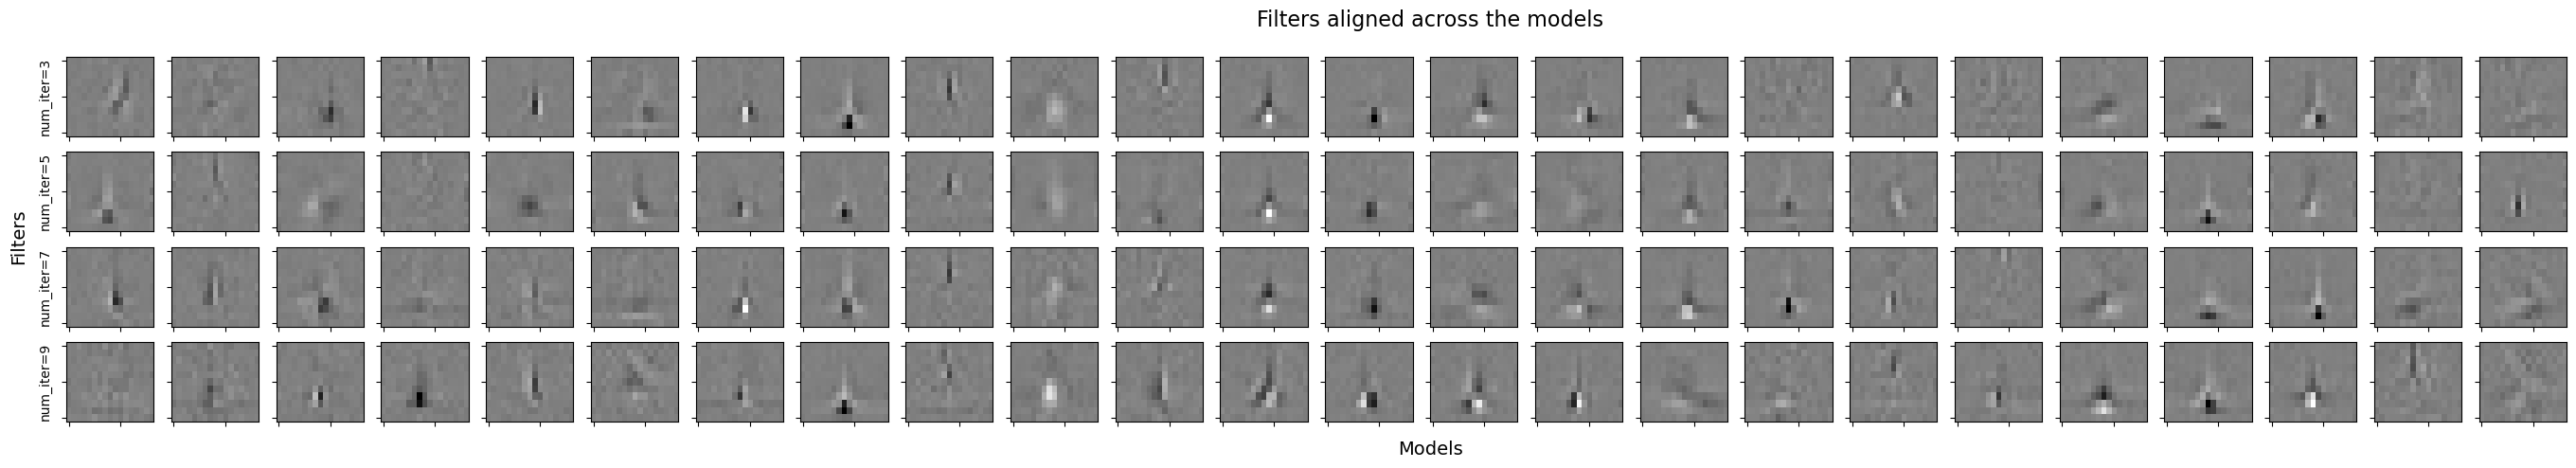

In [208]:
plot.plot_aligned_filters([trial.model for trial in best_trials.values()], model_names=['num_iter=3', 'num_iter=5', 'num_iter=7', 'num_iter=9'], figsize=(30,5))

In [5]:
# get experiment boundaries (they all use the same dataset)
dataset = e.trials[0].dataset
expt_boundaries = np.concatenate([[0], np.cumsum(dataset.num_units)])
expt_boundaries

lazy loading dataset
Loading ['expt04', 'expt06', 'expt07', 'expt09', 'expt11']
Loading expt04
  Time embedding...
  Done.
Loading expt06
  Time embedding...
  Done.
Loading expt07
  Time embedding...
  Done.
Loading expt09
  Time embedding...
  Done.
Loading expt11
  Time embedding...
  Done.


array([  0,  35,  63,  91, 114, 139])

In [167]:
best_trials[('24.24', '17.7', 2, 3)].model.networks[1].layers[0].weights.shape

(96, 36, 139)

In [6]:
# get the weights of the readout layer for the best models
# and just get the middle space-time filter
center_readout_weights = {}
max_readout_weights = {}
sum_readout_weights = {}
readout_weights_by_neuron = {}
for k,trial in best_trials.items():
    sum_neurons = np.sum(trial.model.networks[1].layers[0].weights[:,:,:], axis=1)
    # make inhibitory weights negative (every 12 weights need to be flipped)
    for i in range(12,sum_neurons.shape[0],24):
        sum_neurons[i:i+12,:] = -sum_neurons[i:i+12,:]
    sum_readout_weights[k] = sum_neurons
    
    max_neurons = np.max(trial.model.networks[1].layers[0].weights[:,:,:], axis=1)
    # make inhibitory weights negative (every 12 weights need to be flipped)
    for i in range(12,max_neurons.shape[0],24):
        max_neurons[i:i+12,:] = -max_neurons[i:i+12,:]
    max_readout_weights[k] = max_neurons
    
    center_neurons = trial.model.networks[1].layers[0].weights[:,15,:]
    # make inhibitory weights negative (every 12 weights need to be flipped)
    for i in range(12,center_neurons.shape[0],24):
        center_neurons[i:i+12,:] = -center_neurons[i:i+12,:]
    center_readout_weights[k] = center_neurons

    neurons = []
    for neuron in range(trial.model.networks[1].layers[0].weights.shape[2]):
        weights = trial.model.networks[1].layers[0].weights[:,:,neuron]
        # make inhibitory weights negative (every 12 weights need to be flipped)
        for i in range(12,weights.shape[0],24):
            weights[i:i+12,:] = -weights[i:i+12,:]
        neurons.append(weights)
    readout_weights_by_neuron[k] = neurons

# print a shape to make sure it's right
print(readout_weights_by_neuron.keys())
print(readout_weights_by_neuron['24.24','17.7',2,3][0].shape)
print(center_readout_weights['24.24','17.7',2,3].shape)
print(max_readout_weights['24.24','17.7',2,3].shape)
print(sum_readout_weights['24.24','17.7',2,3].shape)

dict_keys([('24.24', '17.7', 2, 3), ('24.24', '17.7', 2, 5), ('24.24', '17.7', 2, 7), ('24.24', '17.7', 2, 9)])
(96, 36)
(96, 139)
(96, 139)
(96, 139)


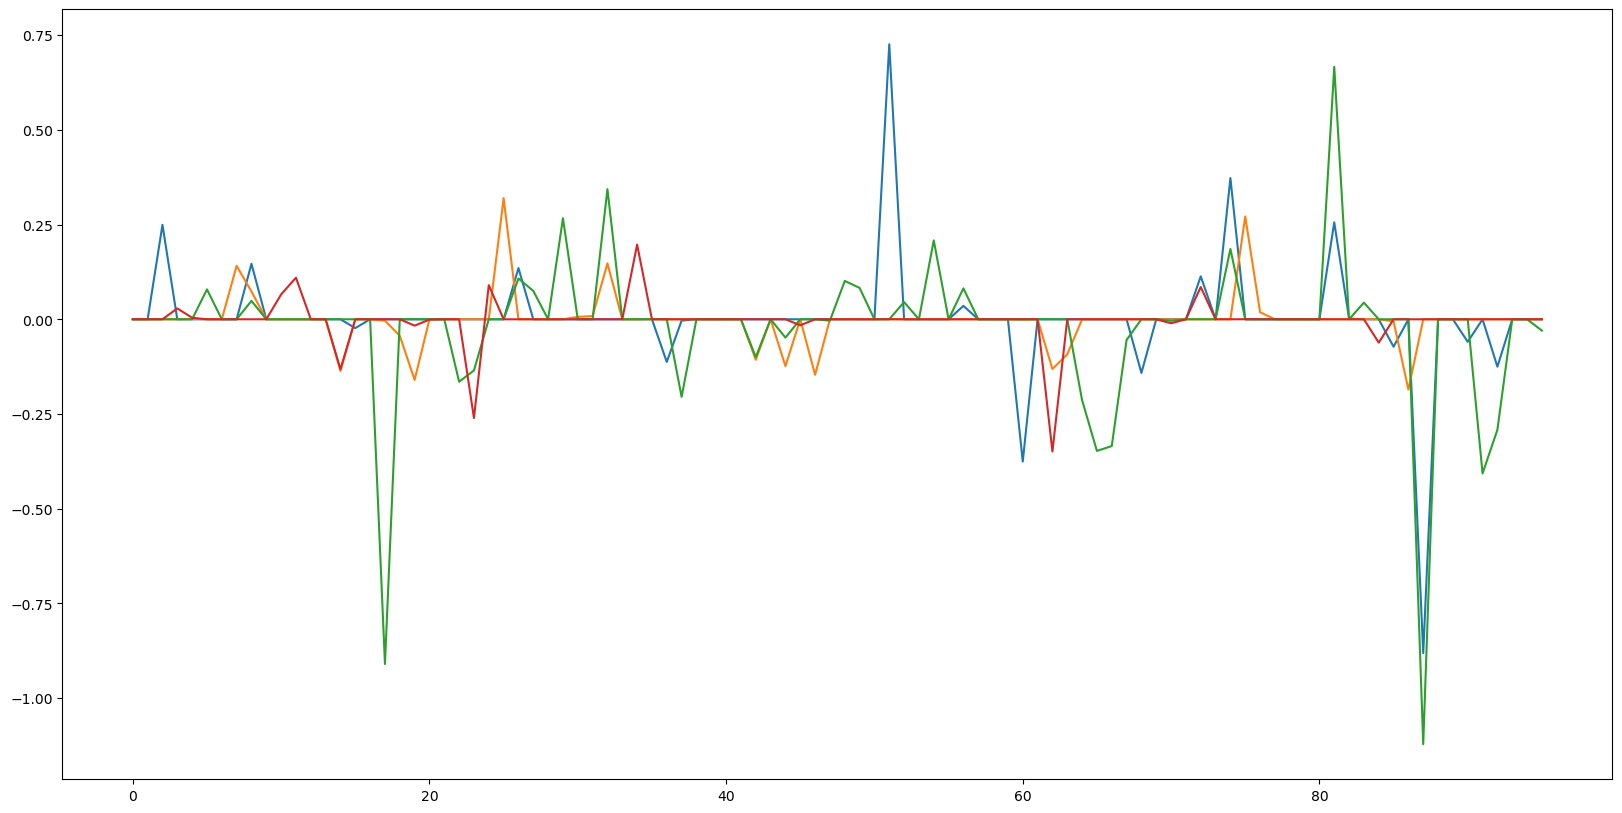

In [7]:
# plot one of the readout weights
fig = plt.figure(figsize=(20,10))
for i in range(4):
    _ = plt.plot(center_readout_weights['24.24','17.7',2,3][:,i])

In [171]:
dataset.SUs

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  35,  36,
        37,  38,  39,  63,  64,  65,  66,  91,  92,  93, 114, 115, 116,
       117, 118, 119, 120, 121, 122])

# plot the readout weights for each model

[10 15 19 22]


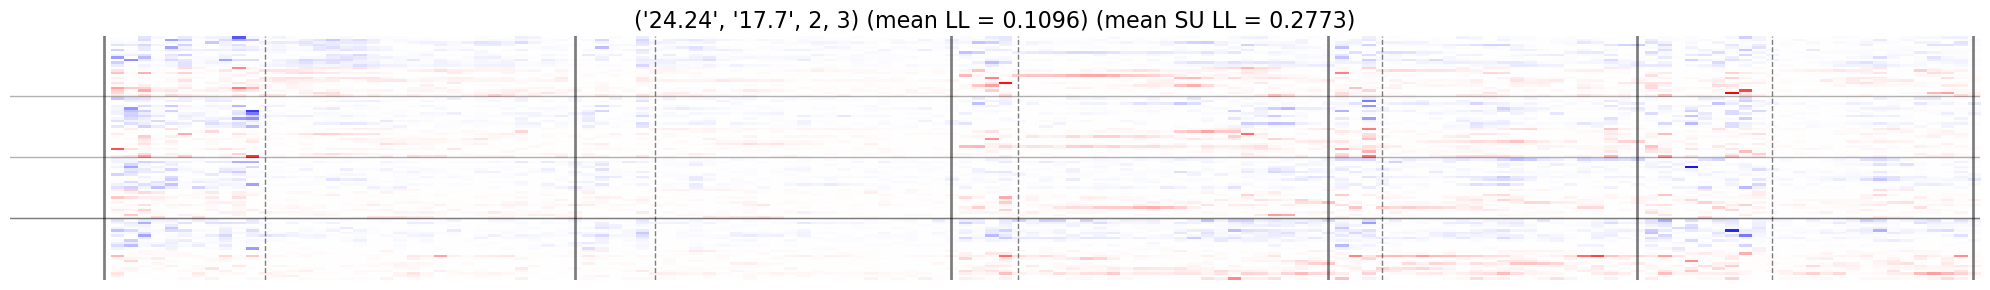

[10 15 19 22]


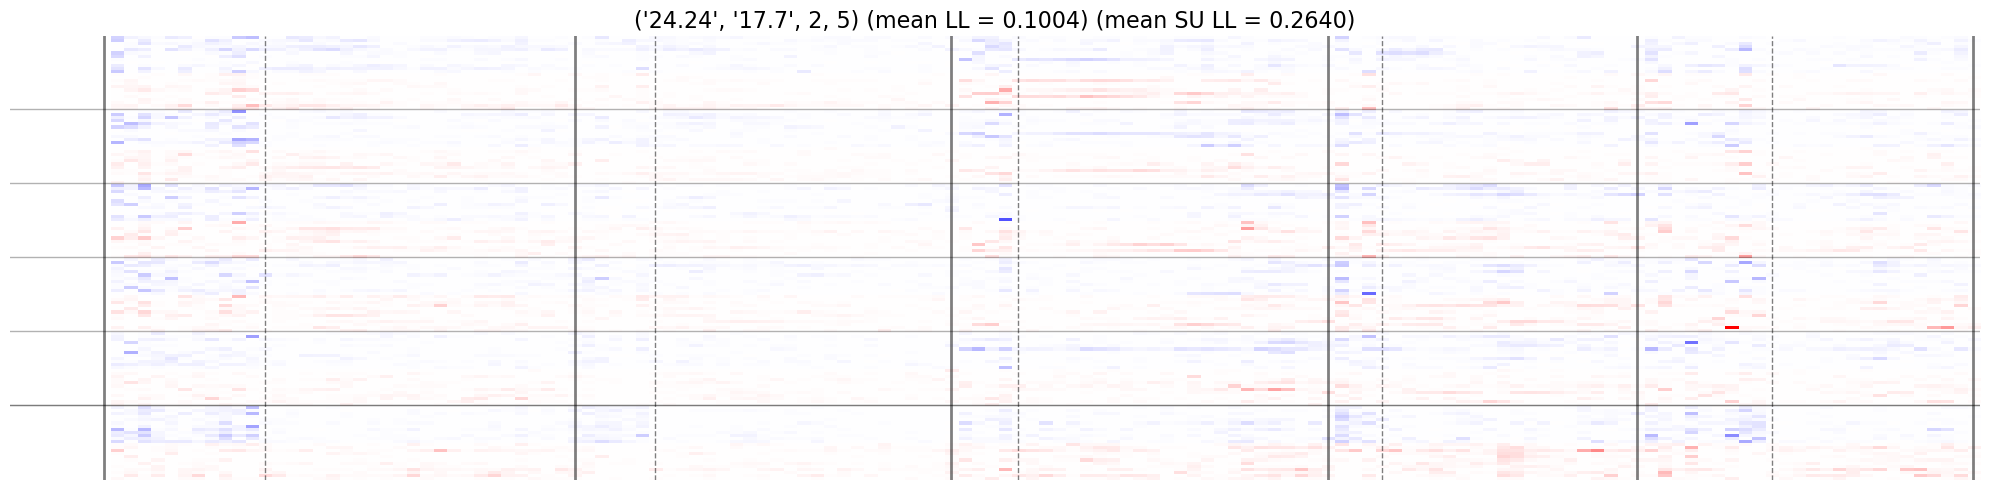

[10 15 19 22]


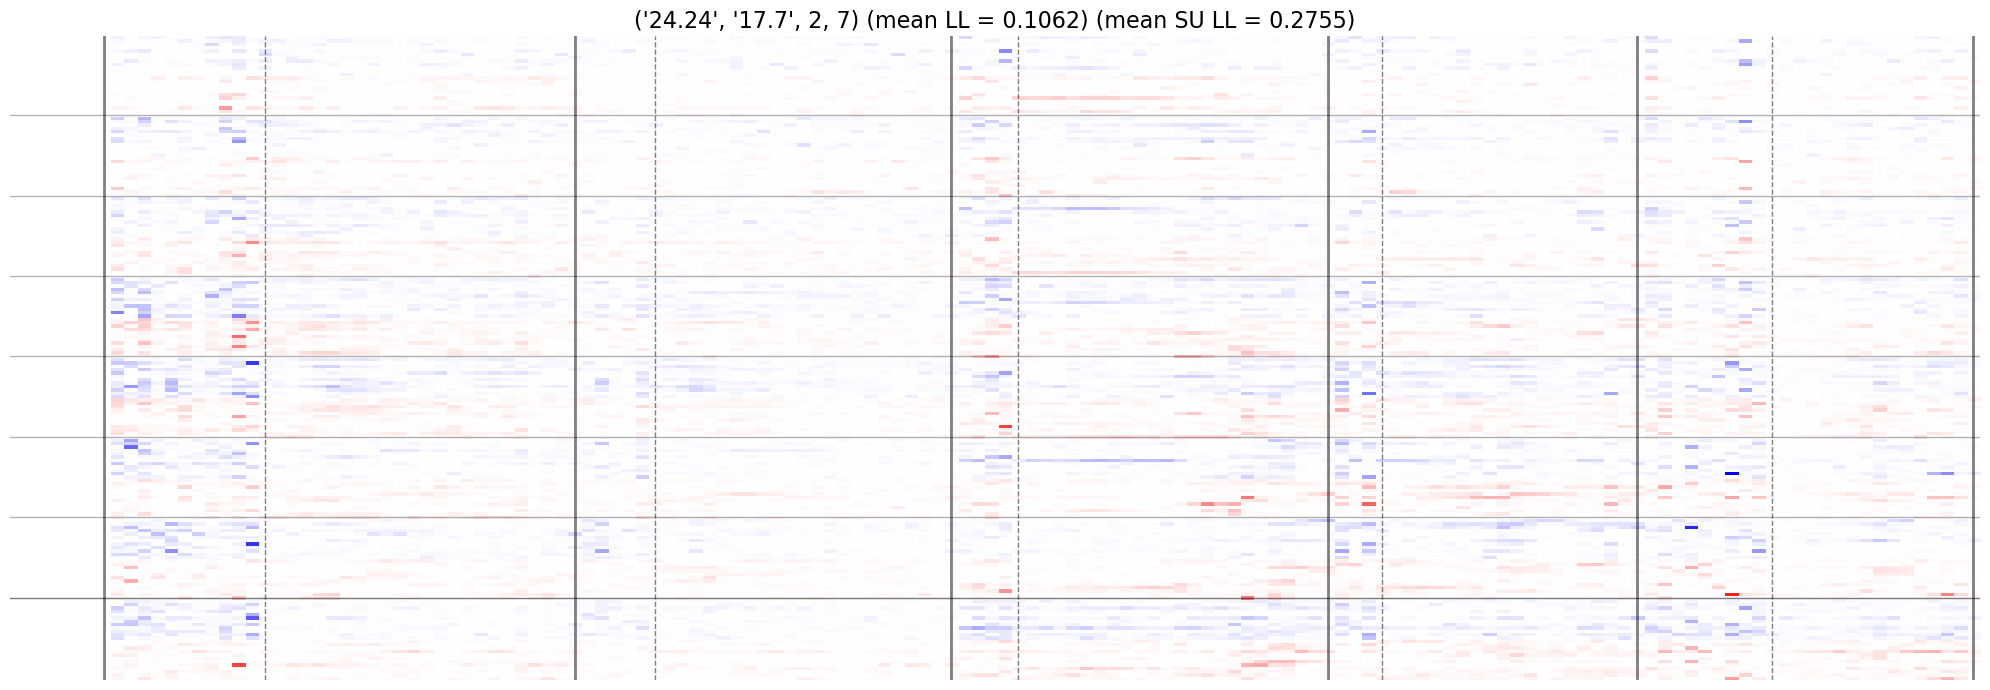

[10 15 19 22]


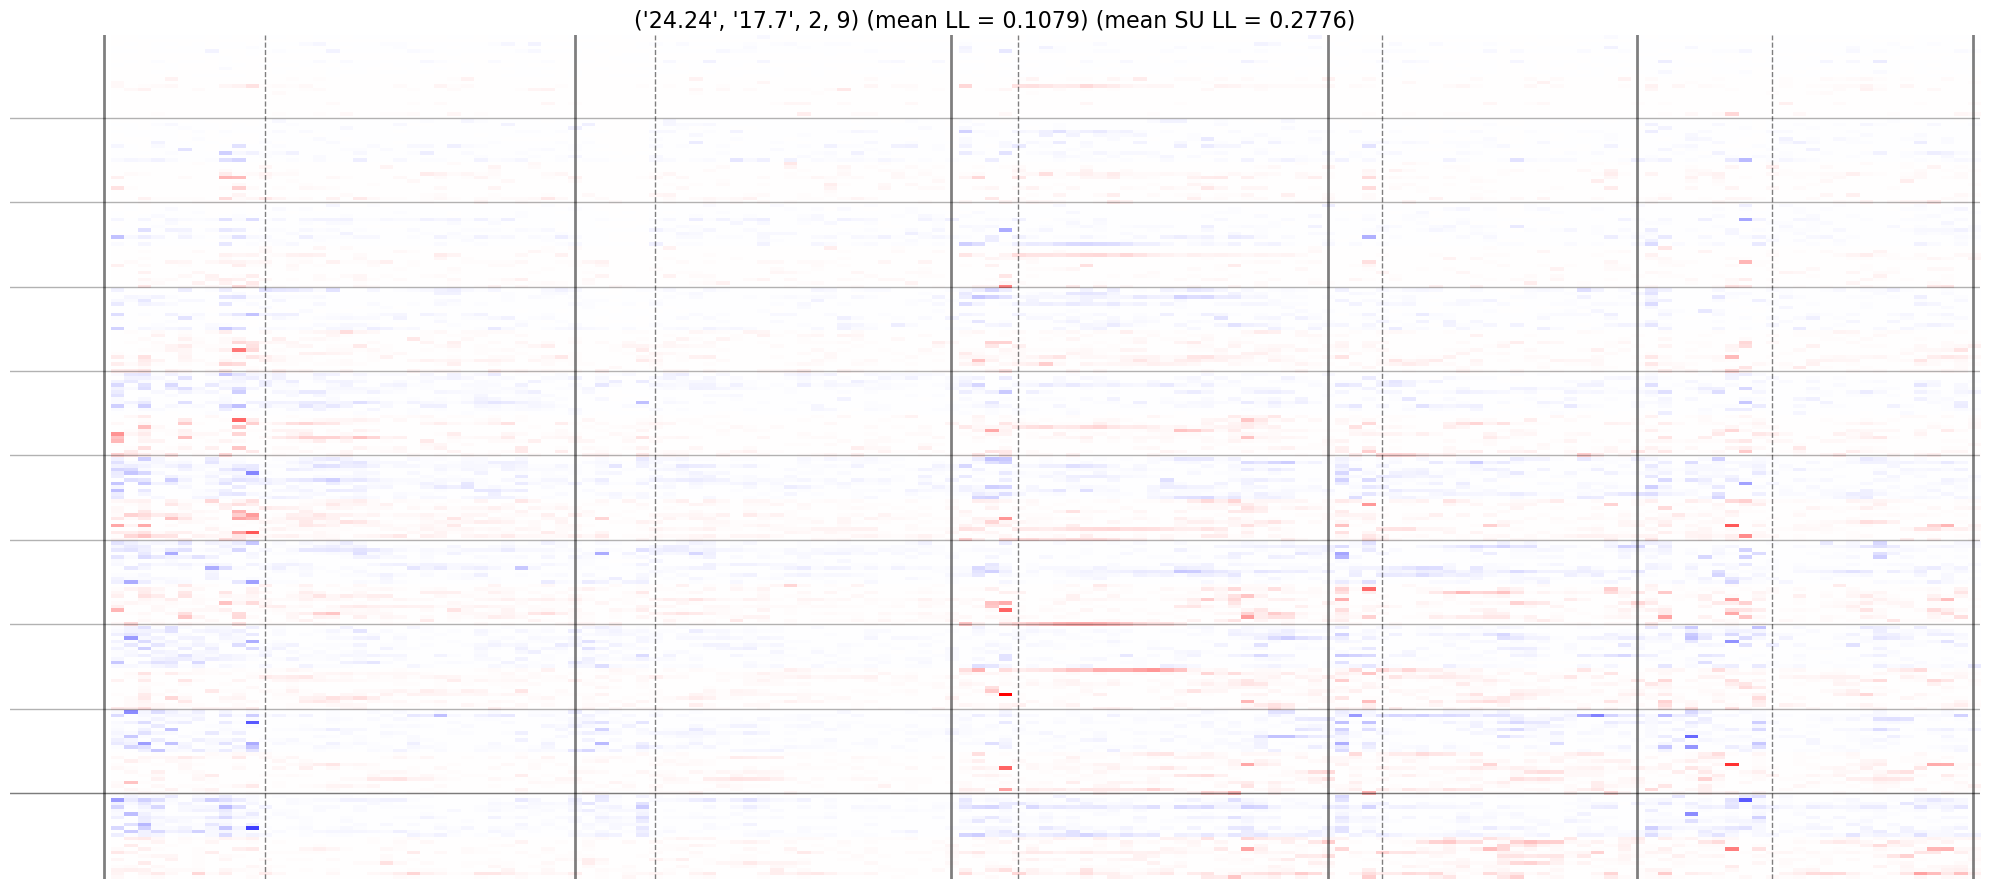

In [188]:
def plot_readout_weights(readout_weights, k, figsize=(20,5)):
    # get the mean LLs for just the SUs in k
    mean_SU_LLs = np.mean(best_trials[k].LLs[dataset.SUs])
    
    # get the mean LLs for k
    mean_LLs = np.mean(best_trials[k].LLs)
    
    fig = plt.figure(figsize=figsize)
    num_subunits, filter_widths, num_lags, num_iter = k
    plot.imagesc(readout_weights[k], cmap='bwr', colrow=False)
    plt.title(str(k) + ' (mean LL = %.4f)' % mean_LLs + ' (mean SU LL = %.4f)' % mean_SU_LLs, fontsize=16)
    plt.axis('off')

    # put a vertical line between each experiment
    for expt_boundary in expt_boundaries:
        plt.axvline(expt_boundary-1, color='k', linewidth=2, alpha=0.5)
        
    # put a vertical line between the SUs and the MUs
    # get the indices of the SUs where the experiment boundaries are
    SU_boundaries = np.where(np.diff(dataset.SUs) > 1)[0]
    print(SU_boundaries)
    
    for SU_boundary in SU_boundaries:
        plt.axvline(dataset.SUs[SU_boundary]+1, color='k', linewidth=1, alpha=0.5, linestyle='--')
    # plot the last SU boundary
    plt.axvline(dataset.SUs[-1]+1, color='k', linewidth=1, alpha=0.5, linestyle='--')

    # put a horizontal line between each layer
    layer_boundaries = [int(num_subunits.split('.')[0])]
    for layer in range(1, num_iter+1):
        layer_boundaries.append(layer*int(num_subunits.split('.')[1]))
    for layer_boundary in layer_boundaries:
        plt.axhline(layer_boundary, color='k', linewidth=1, alpha=0.3)

    plt.tight_layout()
    plt.show()
    
for k in center_readout_weights.keys():
    num_iter = int(k[3])
    plot_readout_weights(sum_readout_weights, k, figsize=(20,num_iter))

# cluster the weights by neuron

In [10]:
def plot_cluster_readout_weights(readout_weights, k, figsize=(10,5)):
    fig = plt.figure(figsize=figsize)
    expts = range(1, len(expt_boundaries))
    colors = ['red', 'orange', 'green', 'blue', 'black']
    print(list(zip(colors, expts)))
    # get the readout weights for the first key
    readout_weights_k = readout_weights[k].T
    
    # scale the weights
    scaled_readout_weights_k = StandardScaler().fit_transform(readout_weights_k)

    # cluster the weights
    clusterable_embedding = umap.UMAP(
        n_components=2,
        random_state=42
    ).fit_transform(scaled_readout_weights_k)

    # color by the experiment they came from
    expt_colors = np.zeros(readout_weights_k.shape[0])
    for i in range(len(expt_boundaries)-1):
        expt_colors[expt_boundaries[i]:expt_boundaries[i+1]] = i

    cmap = matplotlib.colors.ListedColormap(colors)

    # plot the clusters
    plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=30, c=expt_colors, cmap=cmap)
    plt.title(k)
    plt.show()

[('red', 1), ('orange', 2), ('green', 3), ('blue', 4), ('black', 5)]


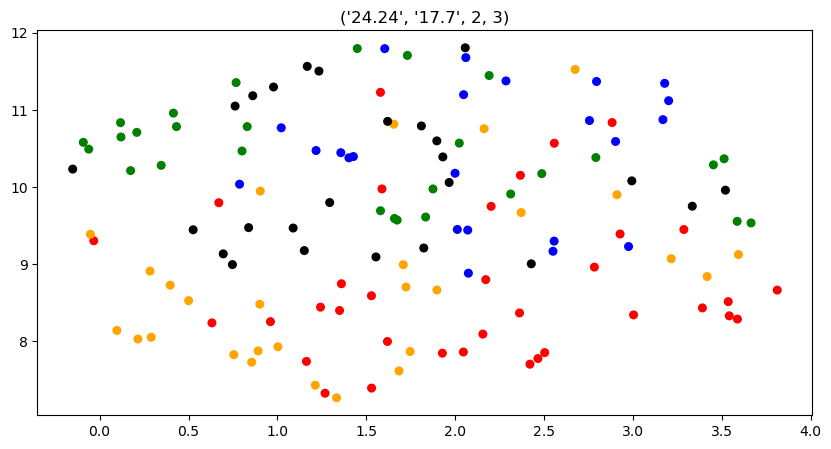

[('red', 1), ('orange', 2), ('green', 3), ('blue', 4), ('black', 5)]


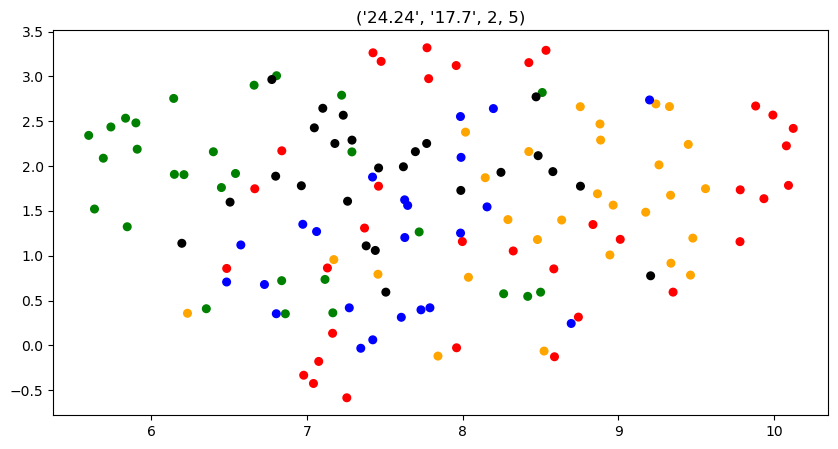

[('red', 1), ('orange', 2), ('green', 3), ('blue', 4), ('black', 5)]


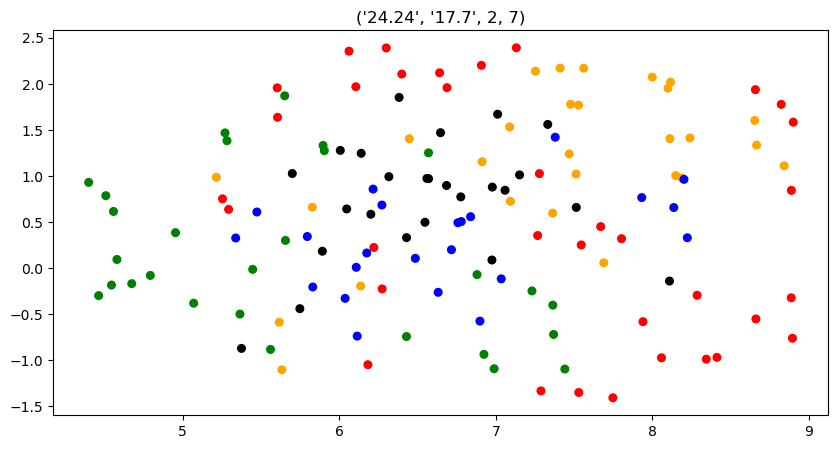

[('red', 1), ('orange', 2), ('green', 3), ('blue', 4), ('black', 5)]


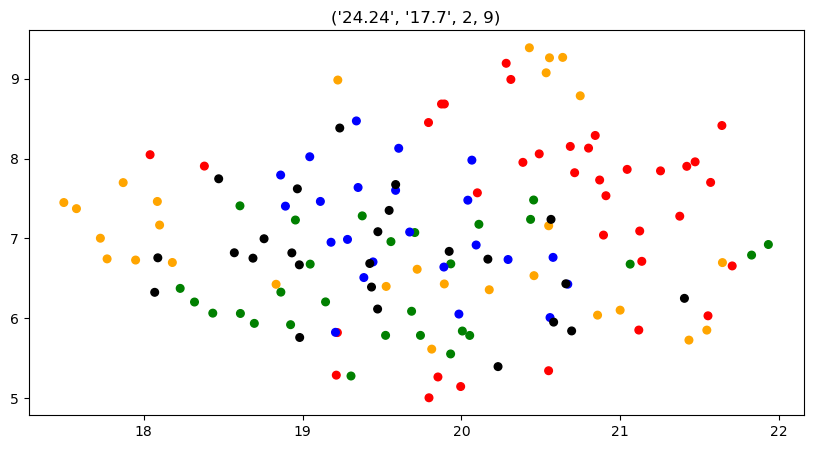

In [11]:
# cluster the neurons by their weights using UMAP
for k in center_readout_weights.keys():
    plot_cluster_readout_weights(center_readout_weights, k)

# plot STAs

(36, 20, 139)


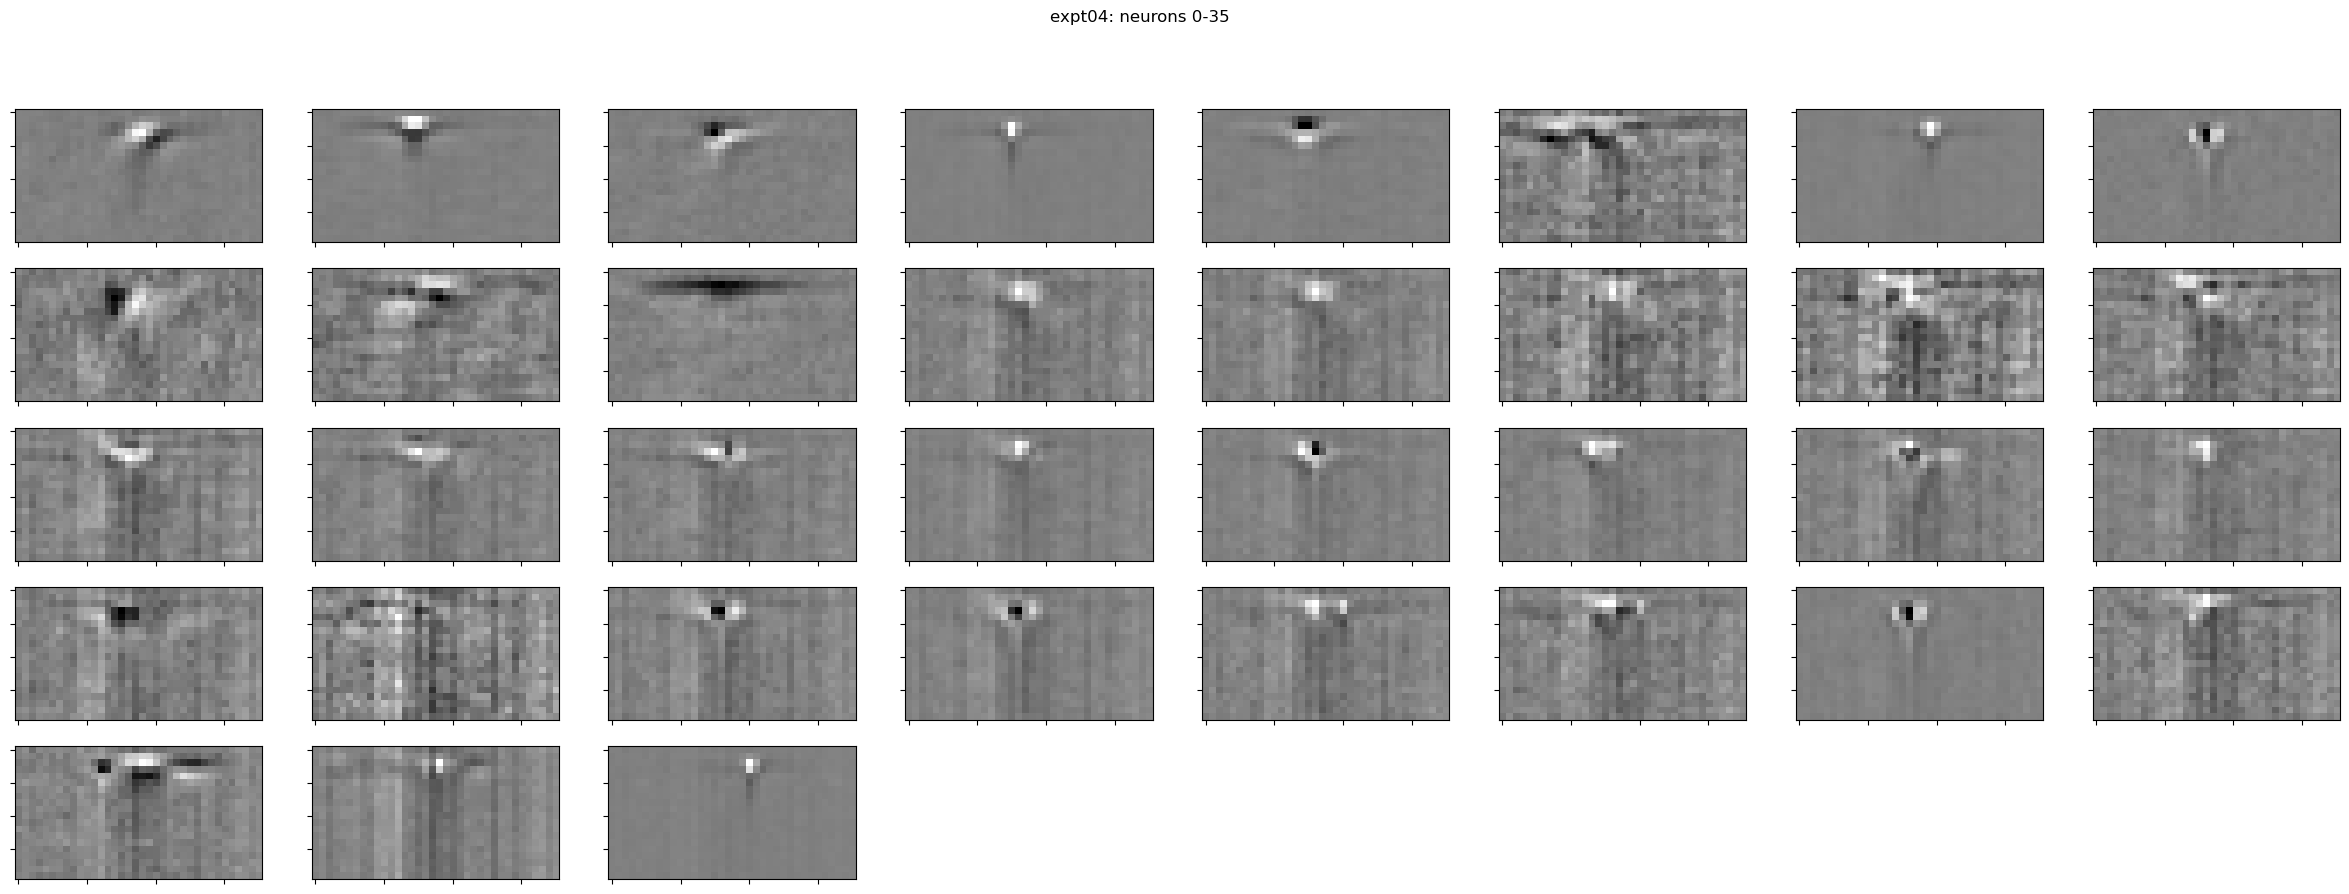

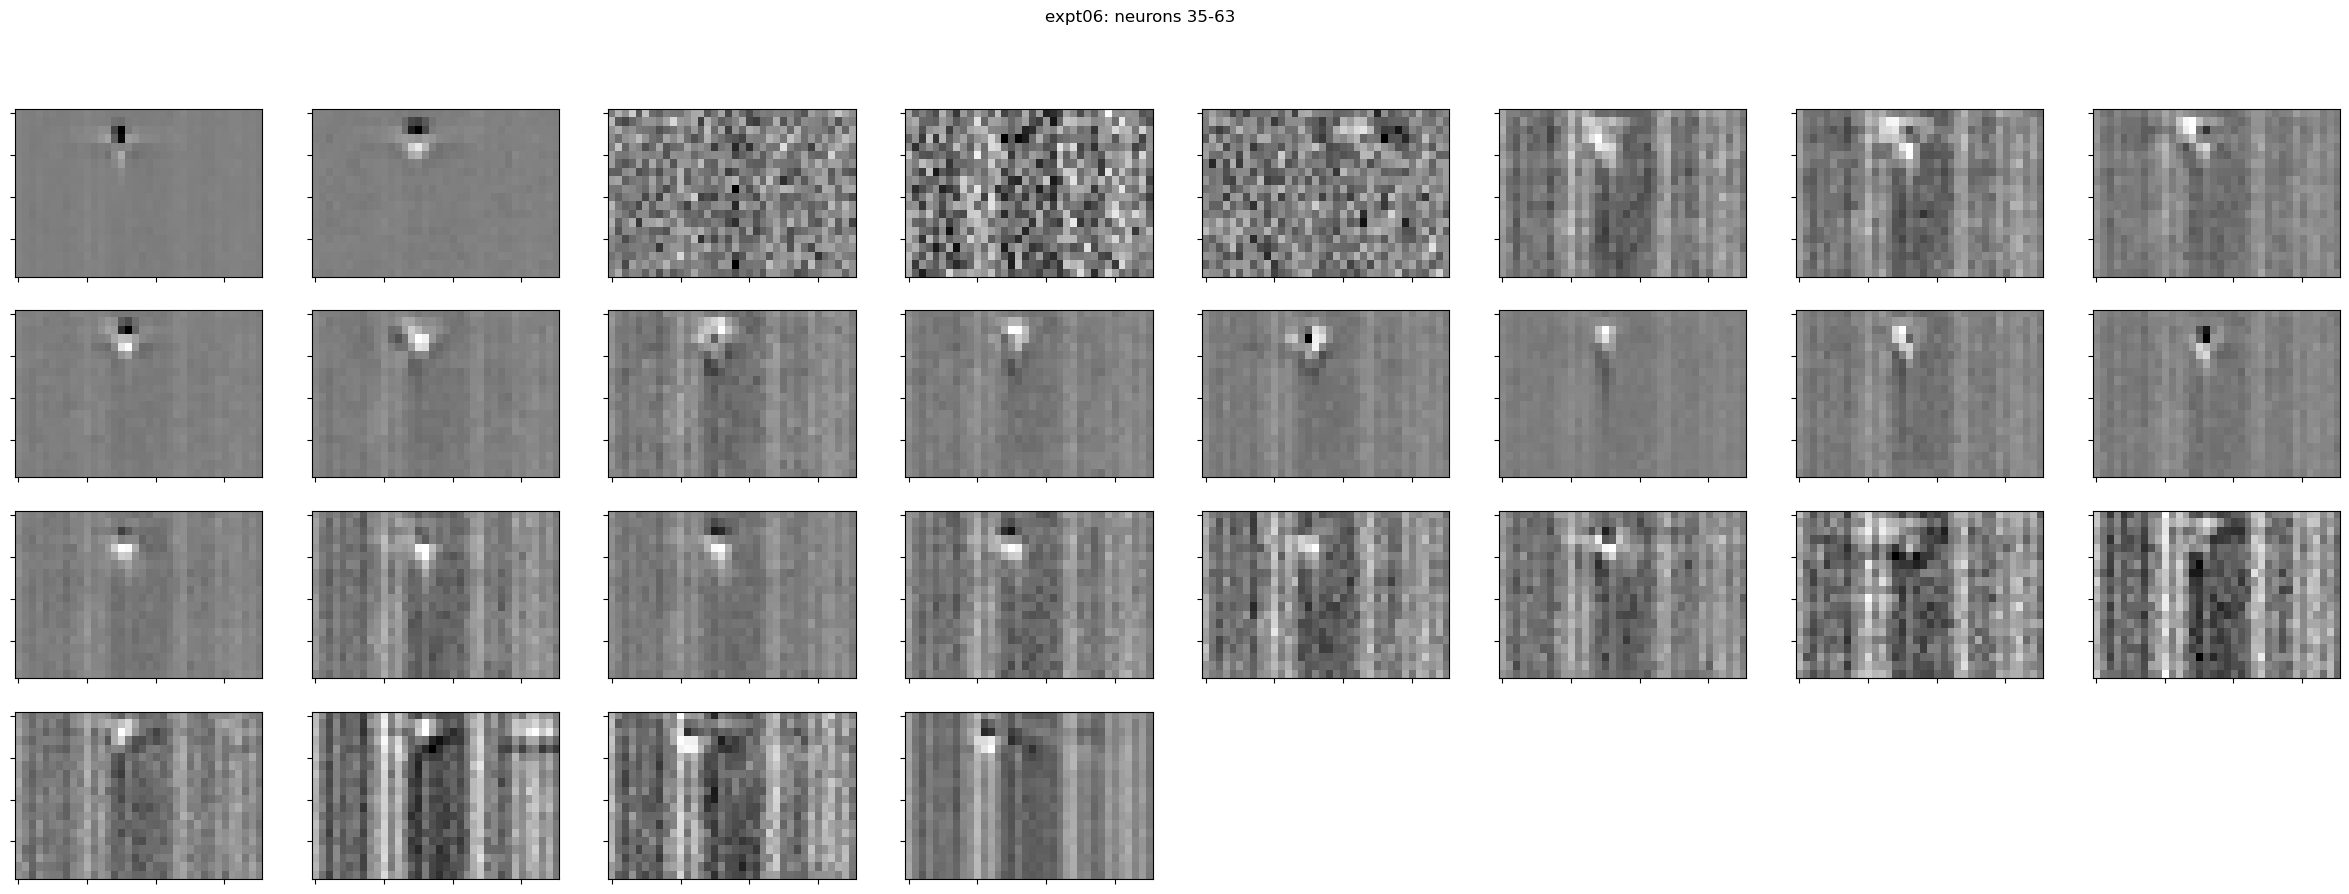

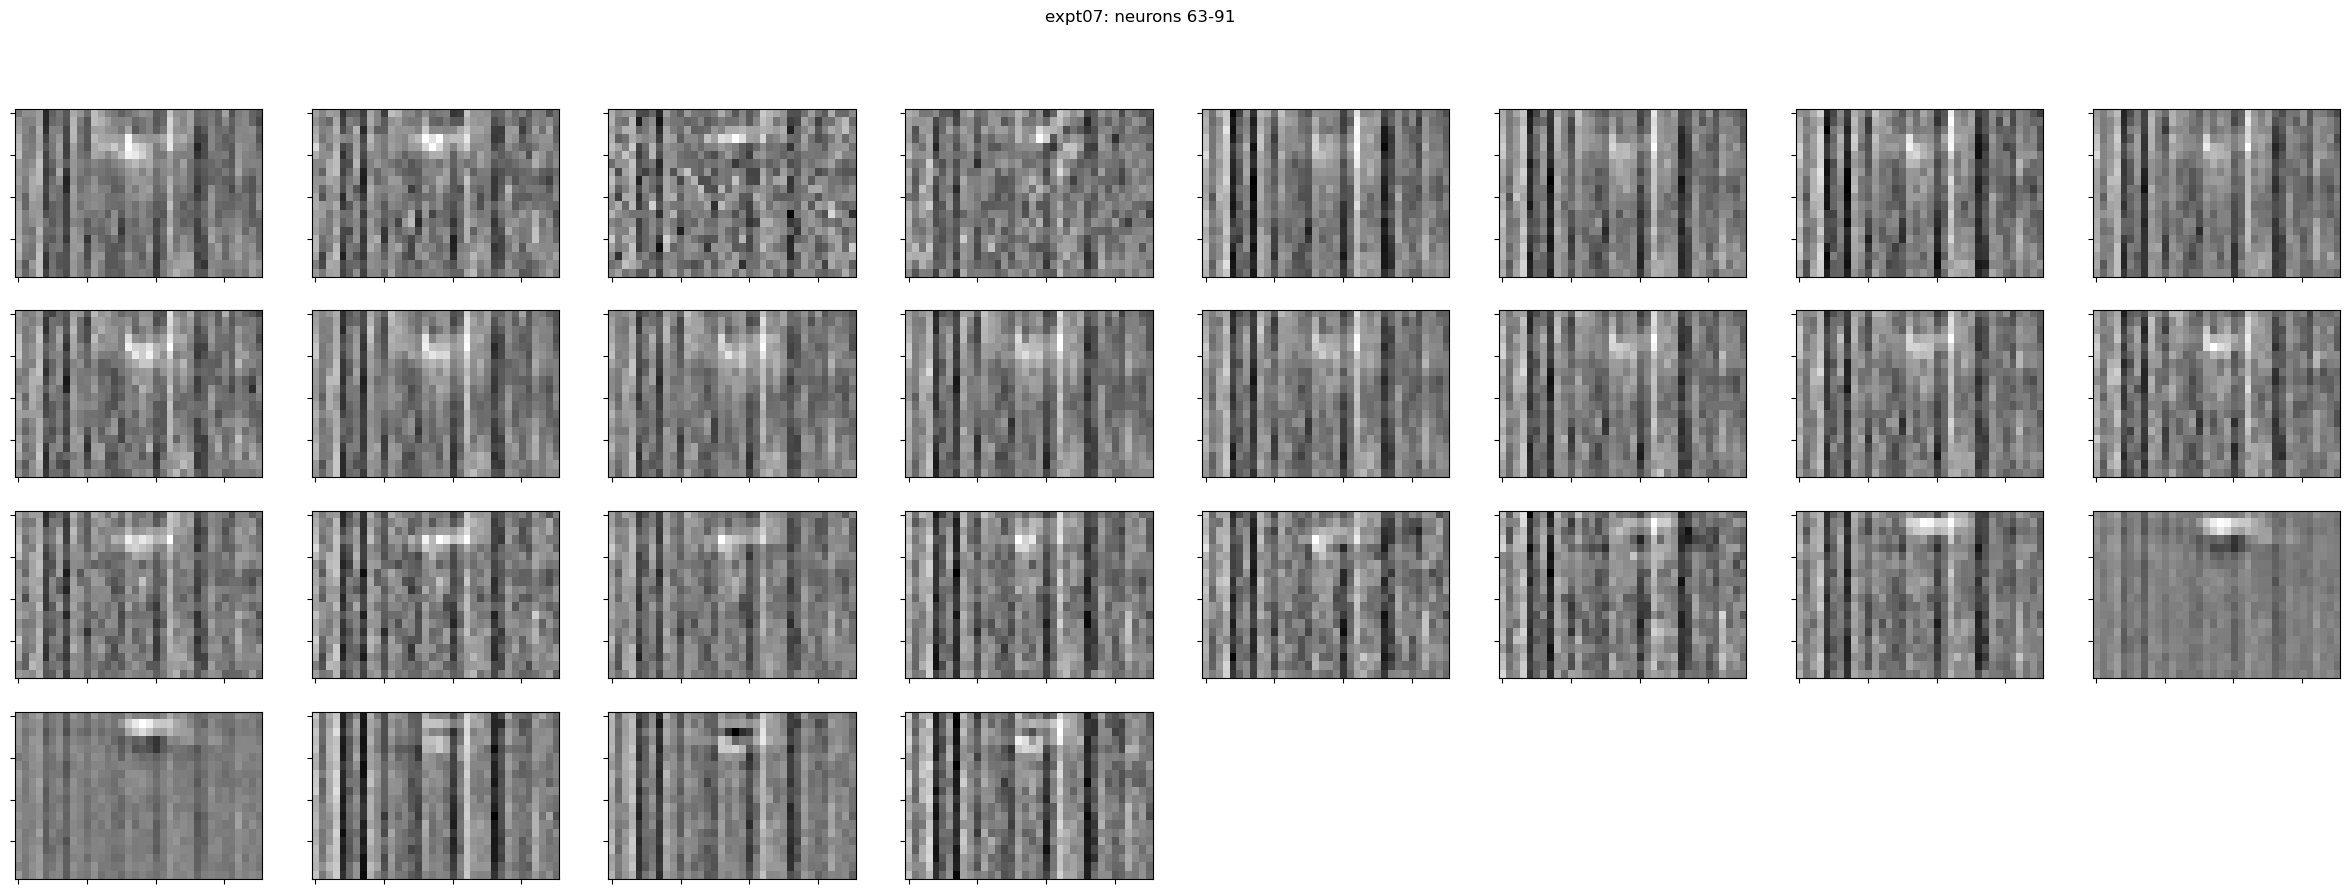

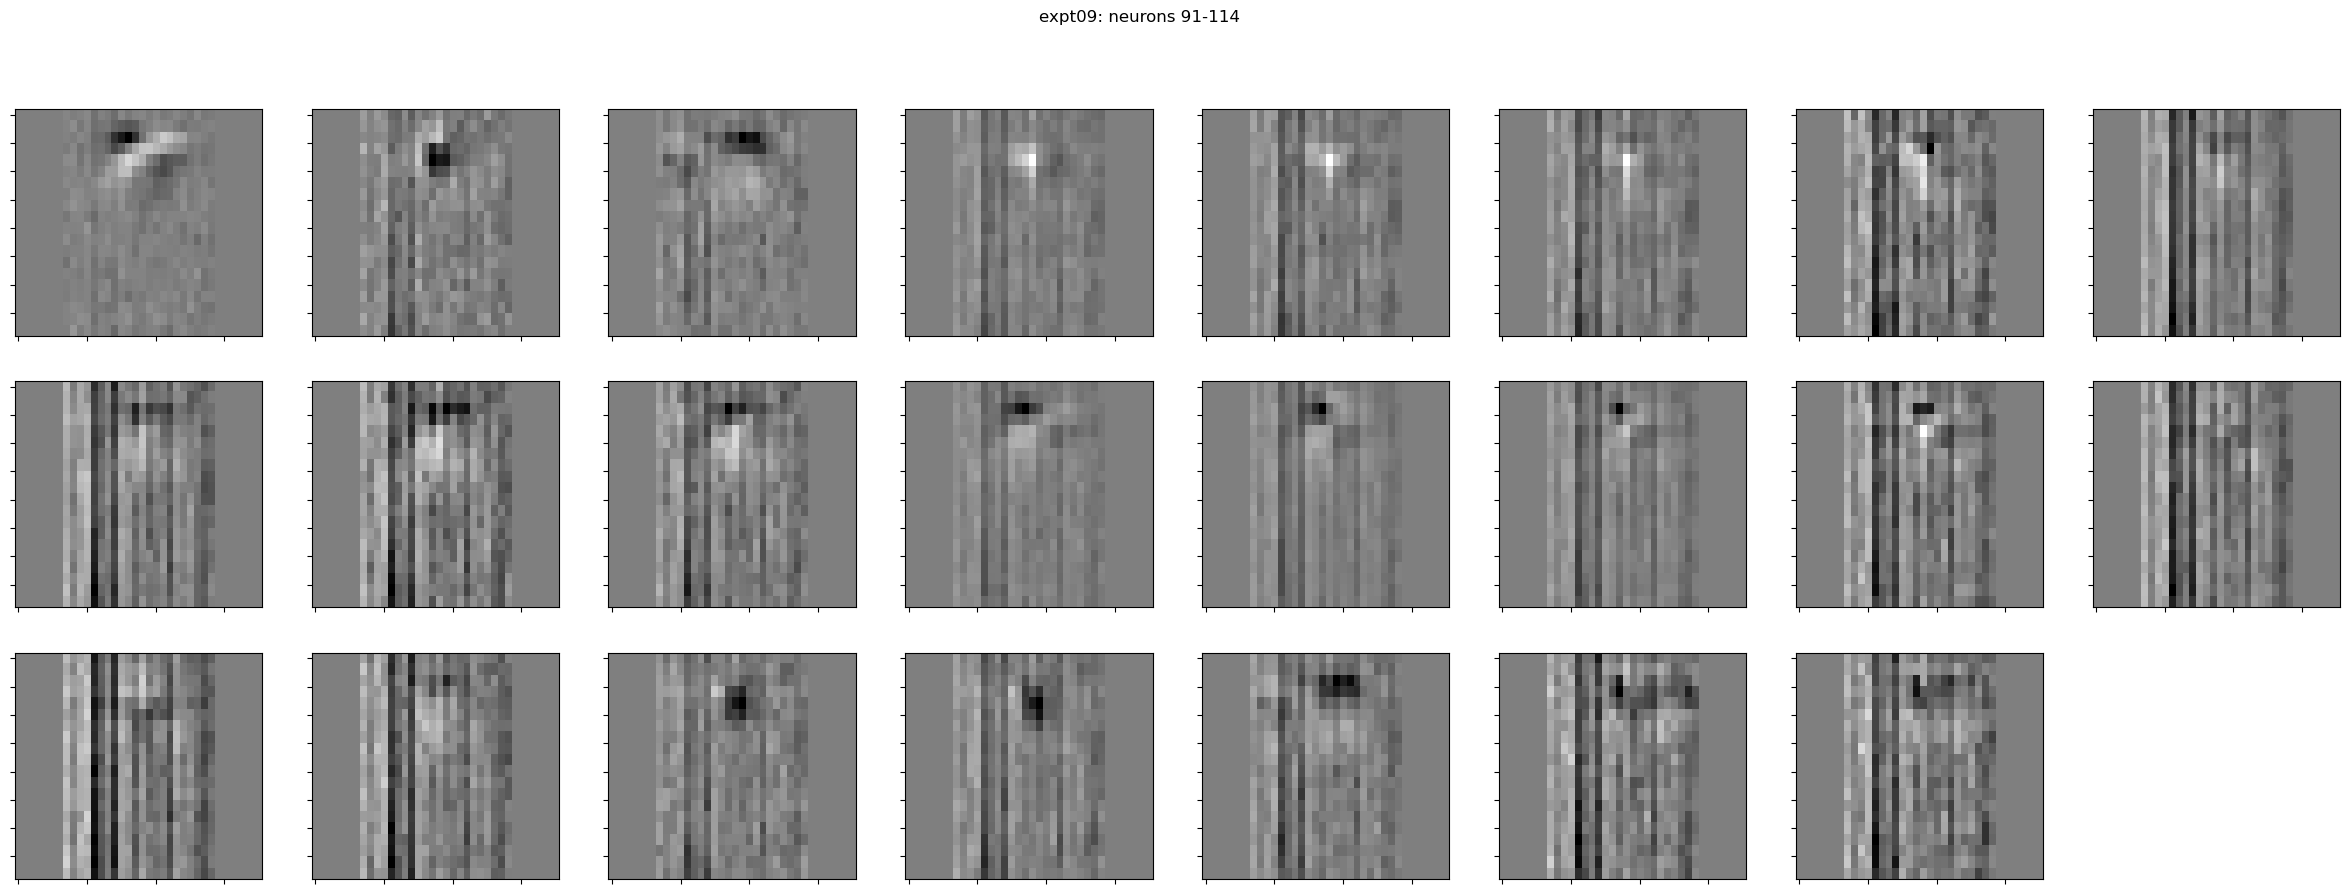

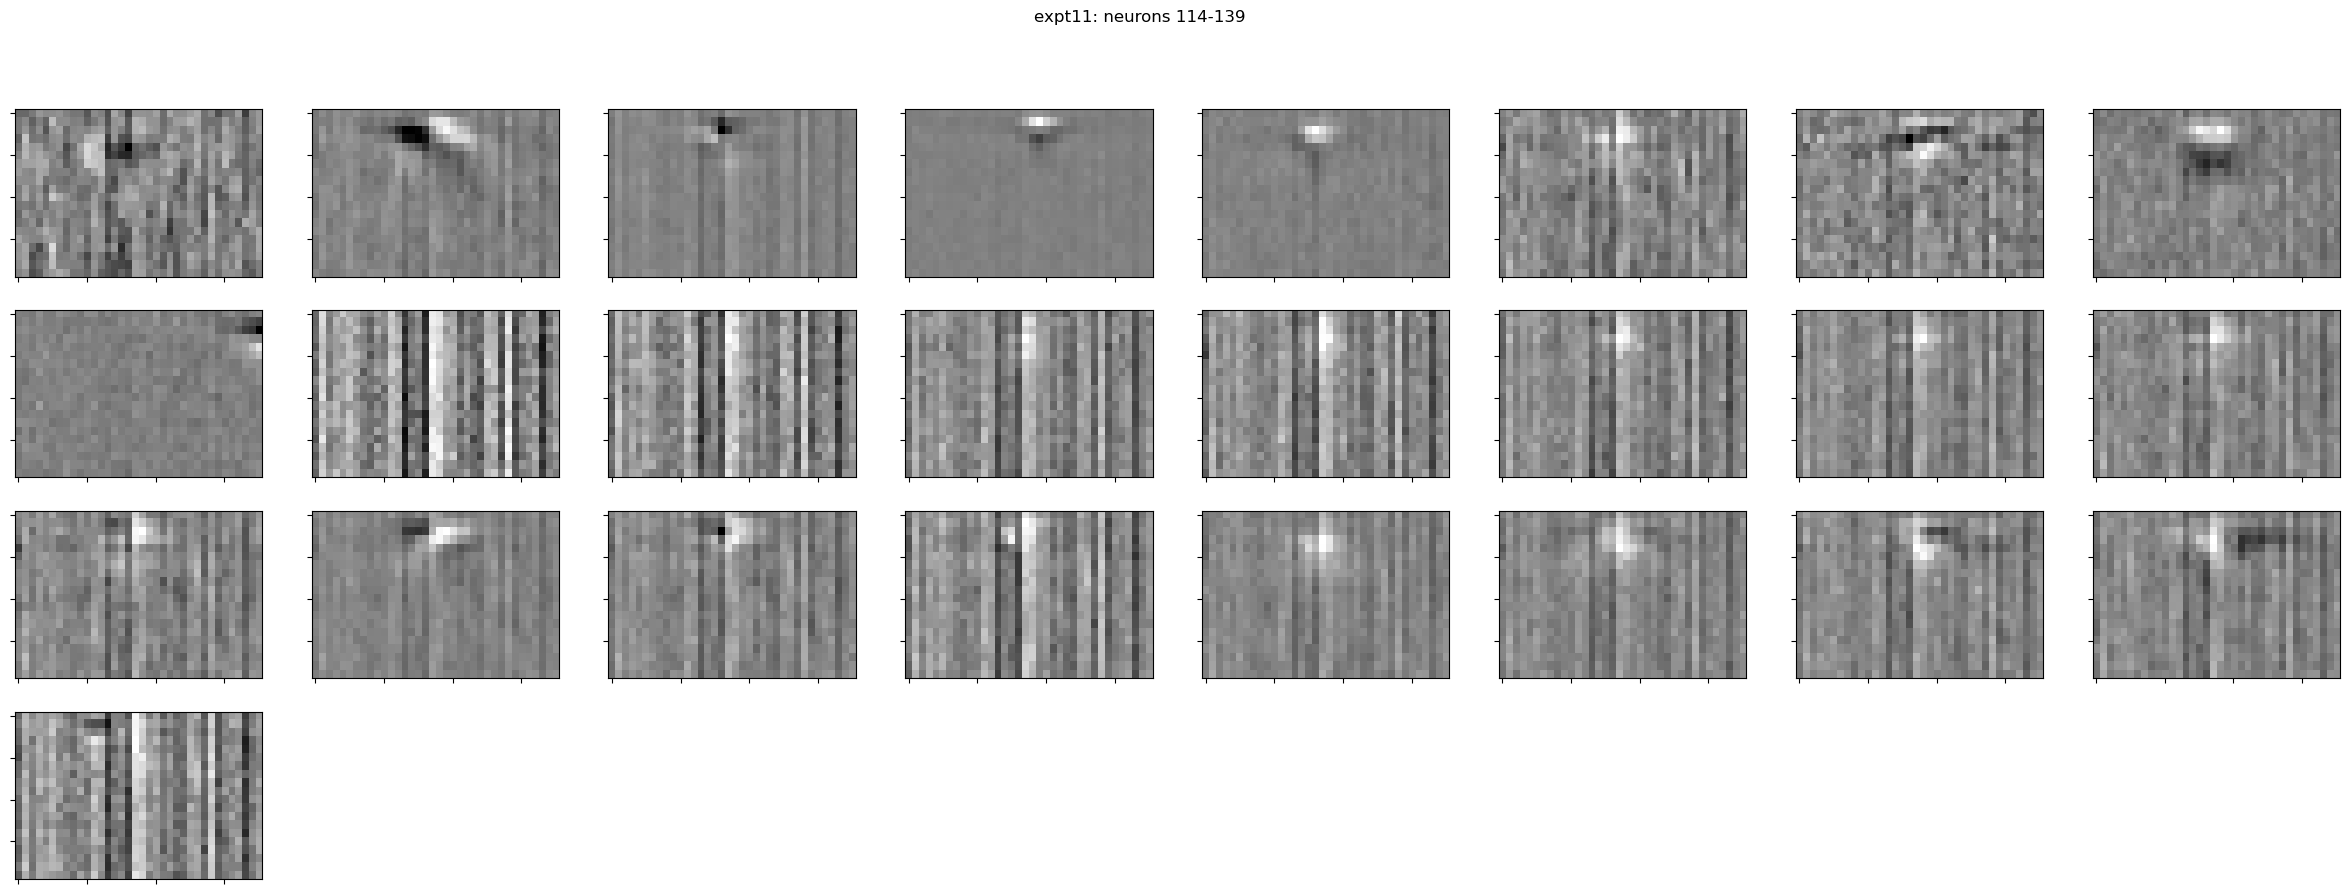

In [12]:
# Calculate STA
num_lags = 20
Reff = dataset.robs * dataset.dfs
nspks = torch.sum(Reff, axis=0)
stas = (dataset.stim.T@dataset.robs / nspks).reshape([-1, num_lags, dataset.NC]).detach().numpy()
print(stas.shape)

# plot first 6 STAs
for expti in range(len(expt_boundaries)-1):
    fig = plt.figure(figsize=(30, 10))
    fig.suptitle(expts[expti]+': neurons '+str(expt_boundaries[expti])+'-'+str(expt_boundaries[expti+1]))
    for i, cc in enumerate(range(expt_boundaries[expti], expt_boundaries[expti+1])):
        expt_len = expt_boundaries[expti+1] - expt_boundaries[expti]
        plt.subplot(expt_len//8+1, 8, i+1)
        plot.imagesc(stas[:, :, cc], aspect='auto', cmap='gray_r', colrow=True, axis_labels=False)

# reweight the subunits

In [13]:
# # reweight the subunits by their connection to the readout layer
# # get the readout layer weights
# readout_weights = model.networks[1].layers[0].weights
# # get the subunit weights
# subunit_weights = model.networks[0].layers[0].weights
# 
# # swap the last and first axes of the subunit weights
# subunit_weights = np.swapaxes(subunit_weights, 0, 2)
# 
# # reweight the subunits
# reweighteds = [] # layer, neuron, subunit
# for neuron in range(11):
#     reweighted_layer = []
#     for layer in range(5):
#         reweighted_neuron = []
#         for i,readout_weight in enumerate(readout_weights[20:30,15,neuron]):
#             reweighted = readout_weight * subunit_weights[i,:,:]
#             reweighted_neuron.append(reweighted)
#         reweighted_layer.append(reweighted_neuron)
#     reweighteds.append(reweighted_layer)
# 
# # get the min and max of the reweighted subunits
# imax = np.max(reweighteds)
# imin = -imax
# print('max: ', imax, 'min: ', imin)
# 
# # plot the reweighted subunits for neuron 1
# fig, axs = plt.subplots(5,10, figsize=(20,6))
# for layer in range(5):
#     for i,reweighted in enumerate(reweighteds[layer][1]):
#         ax = axs[layer,i]
#         ax.imshow(reweighted, cmap='gray', origin='lower', vmin=imin, vmax=imax)
#         ax.axis('off')
# plt.tight_layout()
# plt.suptitle('Reweighted Subunits for Neuron 1', fontsize=20)
# # put spacing between the title and the subplots
# plt.subplots_adjust(top=0.85)
# # label the super axes large font
# fig.text(0.5, 0, 'Subunit', ha='center', va='center', fontsize=16)
# fig.text(0, 0.5, 'Layer', ha='center', va='center', rotation='vertical', fontsize=16)
# plt.show()